# Transformer

## Importation

In [7]:
#!pip install datasets
#!pip install scikit-learn

In [8]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from datasets import load_dataset
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score

## Dataset

In [9]:
# Load the dataset
#SUBSET = "unsplit"
#SUBSET = "split"

dataset = load_dataset("dair-ai/emotion", "split")
dataset_split = load_dataset("dair-ai/emotion", "split")

# Split into train, validation, and test sets
train_set = dataset["train"]
val_set = dataset_split["validation"]
test_set = dataset_split["test"]

train_sset = train_set.map(lambda x: {"text": x["text"], "labels": [x["label"]]})
val_sset = val_set.map(lambda x: {"text": x["text"], "labels": [x["label"]]})
test_sset = test_set.map(lambda x: {"text": x["text"], "labels": [x["label"]]})

__emotions = [
    "sadness",
    "joy",
    "love",
    "anger",
    "fear",
    "surprise",
]

EMOTION_TO_INDEX = {
    emotion: index for index, emotion in enumerate(__emotions)
}

INDEX_TO_EMOTION = {
    index: emotion for emotion, index in EMOTION_TO_INDEX.items()
}

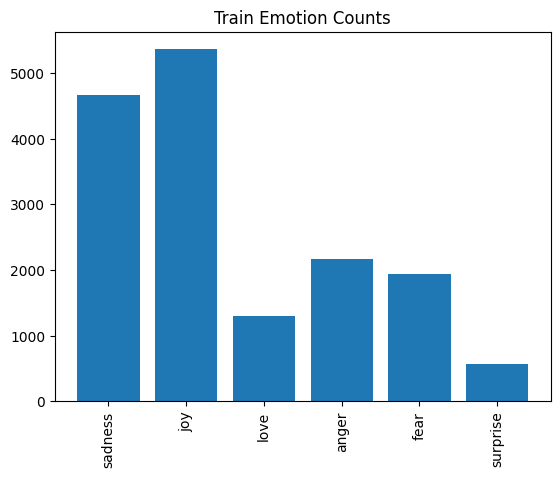

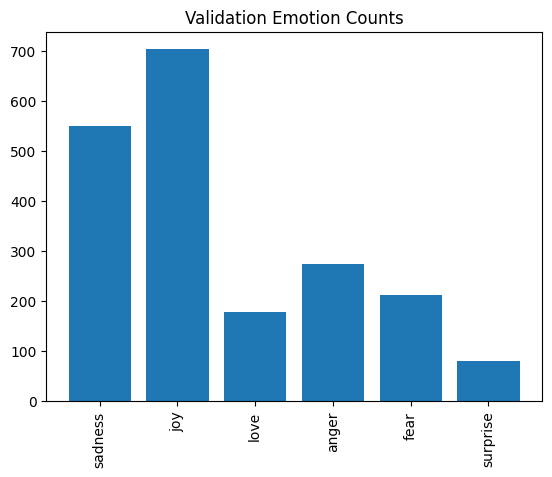

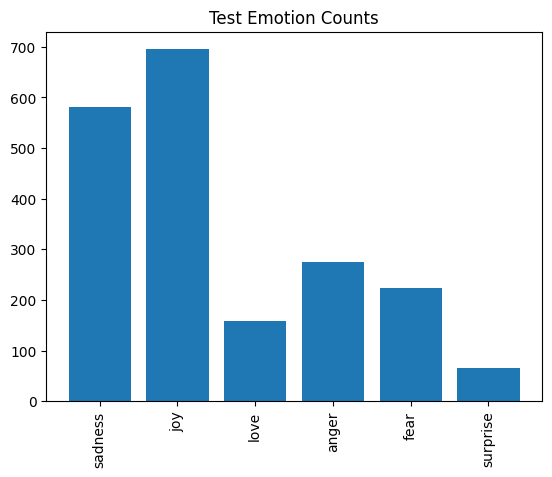

In [10]:
# function to get the number of examples of each emotion in the dataset
def get_emotion_counts(dataset):
    emotion_counts = {}
    for example in dataset:
        for emotion_index in example["labels"]:
            emotion = INDEX_TO_EMOTION[emotion_index]
            if emotion not in emotion_counts:
                emotion_counts[emotion] = 0
            emotion_counts[emotion] += 1
    # sort the emotions in the same order as the __emotions list
    emotion_counts = {emotion: emotion_counts[emotion] for emotion in __emotions}
    return emotion_counts
train_emotion_counts = get_emotion_counts(train_sset)
val_emotion_counts = get_emotion_counts(val_sset)
test_emotion_counts = get_emotion_counts(test_sset)

import matplotlib.pyplot as plt

def plot_emotion_counts(emotion_counts, title):
    plt.bar(emotion_counts.keys(), emotion_counts.values())
    plt.title(title)
    plt.xticks(rotation=90)
    plt.show()

def plot_emotion_counts_as_percentages(emotion_counts, title):
    total = sum(emotion_counts.values())
    percentages = {emotion: count / total for emotion, count in emotion_counts.items()}
    plt.bar(percentages.keys(), percentages.values())
    plt.title(title)
    plt.xticks(rotation=90)
    plt.show()

plot_emotion_counts(train_emotion_counts, "Train Emotion Counts")
plot_emotion_counts(val_emotion_counts, "Validation Emotion Counts")
plot_emotion_counts(test_emotion_counts, "Test Emotion Counts")

## Vocabulary and tokenization functions

In [11]:
import spacy
nlp = spacy.load("en_core_web_sm")

def tokenize(text: str) -> list[str]:
    tokens = nlp(text)
    return [token.lemma_.lower().strip() for token in tokens if not token.is_stop]

def build_vocab(texts, max_vocab_size):
    from collections import Counter
    counter = Counter(token for text in texts for token in tokenize(text))
    most_common = counter.most_common(max_vocab_size - 2)
    vocab = {word: idx + 2 for idx, (word, _) in enumerate(most_common)}  # Reserve 0 and 1
    vocab["<PAD>"] = 0
    vocab["<UNK>"] = 1
    return vocab

def encode(text, vocab, max_len):
    tokens = tokenize(text)
    ids = [vocab.get(token, vocab["<UNK>"]) for token in tokens]
    if len(ids) > max_len:
        return ids[:max_len]
    return ids + [vocab["<PAD>"]] * (max_len - len(ids))

## Build Vocabulary

In [ ]:
# Build vocabulary
all_texts = train_set["text"]
VOCAB_SIZE = 10000
MAX_LEN = 128
vocab = build_vocab(all_texts, VOCAB_SIZE)

## Pytorch Dataset Class

In [13]:
class EmotionDataset(Dataset):
    def __init__(self, texts, labels, vocab, max_len):
        self.texts = texts
        self.labels = labels
        self.vocab = vocab
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        input_ids = torch.tensor(encode(text, self.vocab, self.max_len), dtype=torch.long)
        return {
            "input_ids": input_ids,
            "labels": torch.tensor(label, dtype=torch.long),
        }

## Pytorch data preparation

In [ ]:

# Prepare datasets
train_dataset = EmotionDataset(train_set["text"], train_set["label"], vocab, MAX_LEN)
val_dataset = EmotionDataset(val_set["text"], val_set["label"], vocab, MAX_LEN)
test_dataset = EmotionDataset(test_set["text"], test_set["label"], vocab, MAX_LEN)

# DataLoaders
BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

NUM_CLASSES = len(set(train_set["label"]))  # Number of unique emotions

## Transformer model

In [15]:

class TransformerModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_heads, num_layers, num_classes, max_len, dropout=0.1):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.positional_encoding = nn.Parameter(self._get_positional_encoding(max_len, embed_dim))

        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, dropout=dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.fc = nn.Linear(embed_dim, num_classes)

    def _get_positional_encoding(self, max_len, embed_dim):
        import math
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, embed_dim, 2) * (-math.log(10000.0) / embed_dim))
        pe = torch.zeros(max_len, embed_dim)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        return pe.unsqueeze(0)

    def forward(self, x, attention_mask=None):
        x = self.embedding(x) + self.positional_encoding[:, : x.size(1), :]
        if attention_mask is not None:
            # Convert attention_mask to the expected format for `nn.TransformerEncoder`
            attention_mask = attention_mask == 0  # Mask padded tokens (True for padding)
        x = self.transformer_encoder(x, src_key_padding_mask=attention_mask)
        x = x.mean(dim=1)  # Global pooling
        logits = self.fc(x)
        return logits

## Hyperparameters

In [21]:
EMBED_DIM = 128
NUM_HEADS = 4
NUM_LAYERS = 2
DROPOUT = 0.1
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
EPOCHS = 10

## Model, Loss and Optimizer

In [22]:
# Model, loss, and optimizer
model = TransformerModel(
    vocab_size=len(vocab),
    embed_dim=EMBED_DIM,
    num_heads=NUM_HEADS,
    num_layers=NUM_LAYERS,
    num_classes=NUM_CLASSES,
    max_len=MAX_LEN,
    dropout=DROPOUT,
).to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=5e-4)

## Training function

In [23]:
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs):
    print("Training the model")
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for batch in train_loader:
            input_ids = batch["input_ids"].to(DEVICE)
            labels = batch["labels"].to(DEVICE)

            optimizer.zero_grad()
            outputs = model(input_ids)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        # Validation
        model.eval()
        val_loss = 0
        val_preds, val_labels = [], []
        with torch.no_grad():
            print ("Validating the model")
            for batch in val_loader:
                input_ids = batch["input_ids"].to(DEVICE)
                labels = batch["labels"].to(DEVICE)

                outputs = model(input_ids)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                preds = torch.argmax(outputs, dim=1).cpu().numpy()
                val_preds.extend(preds)
                val_labels.extend(labels.cpu().numpy())

        val_acc = accuracy_score(val_labels, val_preds)
        print(f"Epoch {epoch + 1}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}, Val Acc = {val_acc:.4f}")


In [24]:

# Train the model
train_model(model, train_loader, val_loader, criterion, optimizer, EPOCHS)

# save the model
torch.save(model.state_dict(), "model_split.pth")

Training the model
Validating the model
Epoch 1: Train Loss = 345.3755, Val Loss = 27.8861, Val Acc = 0.6900
Validating the model
Epoch 2: Train Loss = 161.0698, Val Loss = 16.1204, Val Acc = 0.8255
Validating the model
Epoch 3: Train Loss = 97.1109, Val Loss = 12.8045, Val Acc = 0.8635
Validating the model
Epoch 4: Train Loss = 70.0856, Val Loss = 12.2285, Val Acc = 0.8730
Validating the model
Epoch 5: Train Loss = 56.5088, Val Loss = 12.2285, Val Acc = 0.8670
Validating the model
Epoch 6: Train Loss = 44.6566, Val Loss = 11.4751, Val Acc = 0.8820
Validating the model
Epoch 7: Train Loss = 38.0764, Val Loss = 12.8558, Val Acc = 0.8795
Validating the model
Epoch 8: Train Loss = 32.1301, Val Loss = 11.9805, Val Acc = 0.8820
Validating the model
Epoch 9: Train Loss = 29.0531, Val Loss = 12.4891, Val Acc = 0.8870
Validating the model
Epoch 10: Train Loss = 25.6627, Val Loss = 14.9736, Val Acc = 0.8695


In [30]:
from collections import defaultdict
import matplotlib.pyplot as plt

def evaluate_model(model, data_loader, index_to_emotion, device):
    """
    Evaluate the model and compute accuracy per emotion.

    Args:
        model: The trained model.
        data_loader: DataLoader for the evaluation set.
        index_to_emotion: A dictionary mapping label indices to emotion names.
        device: The device to run the evaluation on.

    Returns:
        A dictionary with emotion-wise accuracy and a plot.
    """
    model.eval()
    emotion_correct = defaultdict(int)
    emotion_total = defaultdict(int)
    total_correct = 0
    total_predictions = 0

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch["input_ids"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            labels = labels.cpu().numpy()

            # Update overall accuracy counts
            total_correct += (preds == labels).sum()
            total_predictions += len(labels)

            # Update emotion-specific counts
            for true_label, pred_label in zip(labels, preds):
                true_emotion = index_to_emotion[true_label]
                predicted_emotion = index_to_emotion[pred_label]
                emotion_total[true_emotion] += 1
                if true_emotion == predicted_emotion:
                    emotion_correct[true_emotion] += 1

    # Calculate overall accuracy manually
    overall_accuracy = (total_correct / total_predictions) * 100 if total_predictions > 0 else 0

    # Calculate accuracy per emotion
    emotion_accuracy = {
        emotion: (emotion_correct[emotion] / emotion_total[emotion] * 100)
        if emotion_total[emotion] > 0 else 0
        for emotion in index_to_emotion.values()
    }

    # Plot accuracy per emotion
    plt.figure(figsize=(10, 6))
    plt.bar(emotion_accuracy.keys(), emotion_accuracy.values(), color="skyblue")
    plt.title("Accuracy per Emotion", fontsize=16)
    plt.xlabel("Emotion", fontsize=12)
    plt.ylabel("Accuracy (%)", fontsize=12)
    plt.xticks(rotation=45)
    plt.ylim(0, 100)
    plt.tight_layout()
    plt.show()

    # Print the results
    print(f"Overall Accuracy: {overall_accuracy:.2f}%")
    print("Accuracy per emotion:")
    for emotion, accuracy in emotion_accuracy.items():
        print(f"{emotion}: {accuracy:.2f}%")

    return emotion_accuracy, overall_accuracy


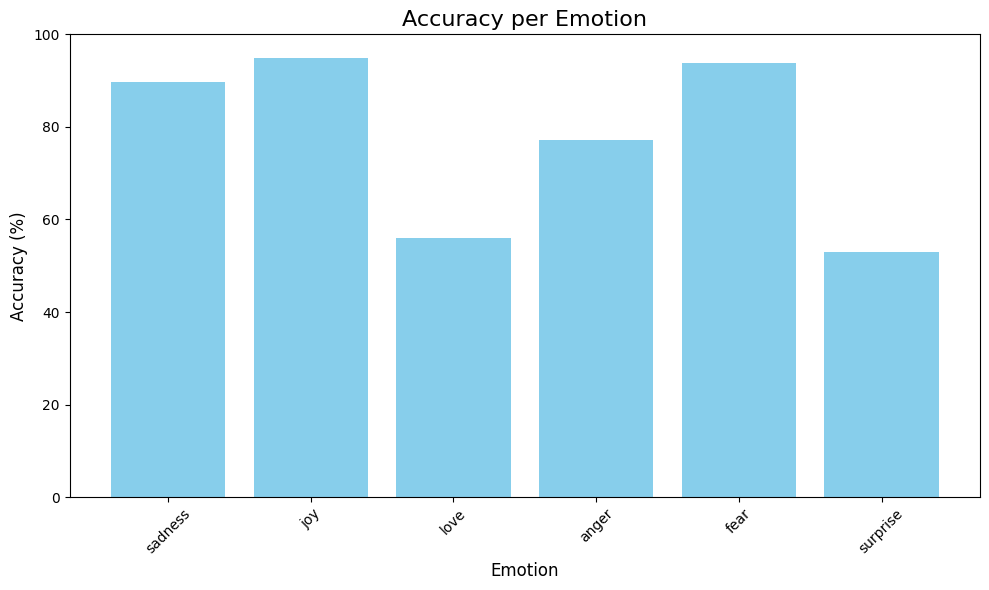

Overall Accuracy: 86.35%
Accuracy per emotion:
sadness: 89.67%
joy: 94.96%
love: 55.97%
anger: 77.09%
fear: 93.75%
surprise: 53.03%


In [26]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Evaluate the trained model
emotion_accuracy = evaluate_model(
    model=model,
    data_loader=test_loader,
    index_to_emotion=INDEX_TO_EMOTION,
    device=DEVICE
)

## GridWorld for Hyperparameters

Learning Rate: 1e-05, Weight Decay: 0.0, Dropout: 0.01
Training the model
Validating the model
Epoch 1: Train Loss = 399.7160, Val Loss = 50.5098, Val Acc = 0.3515
Validating the model
Epoch 2: Train Loss = 393.2810, Val Loss = 50.5307, Val Acc = 0.3400
Validating the model
Epoch 3: Train Loss = 392.5311, Val Loss = 50.3774, Val Acc = 0.3535
Validating the model
Epoch 4: Train Loss = 391.1882, Val Loss = 50.2391, Val Acc = 0.3570
Validating the model
Epoch 5: Train Loss = 389.0010, Val Loss = 49.9340, Val Acc = 0.3585
Validating the model
Epoch 6: Train Loss = 384.8497, Val Loss = 49.3540, Val Acc = 0.3835
Validating the model
Epoch 7: Train Loss = 377.3648, Val Loss = 48.5581, Val Acc = 0.3815
Validating the model
Epoch 8: Train Loss = 366.3613, Val Loss = 47.0064, Val Acc = 0.4225
Validating the model
Epoch 9: Train Loss = 351.0413, Val Loss = 44.8181, Val Acc = 0.4450
Validating the model
Epoch 10: Train Loss = 331.9243, Val Loss = 42.6751, Val Acc = 0.4795


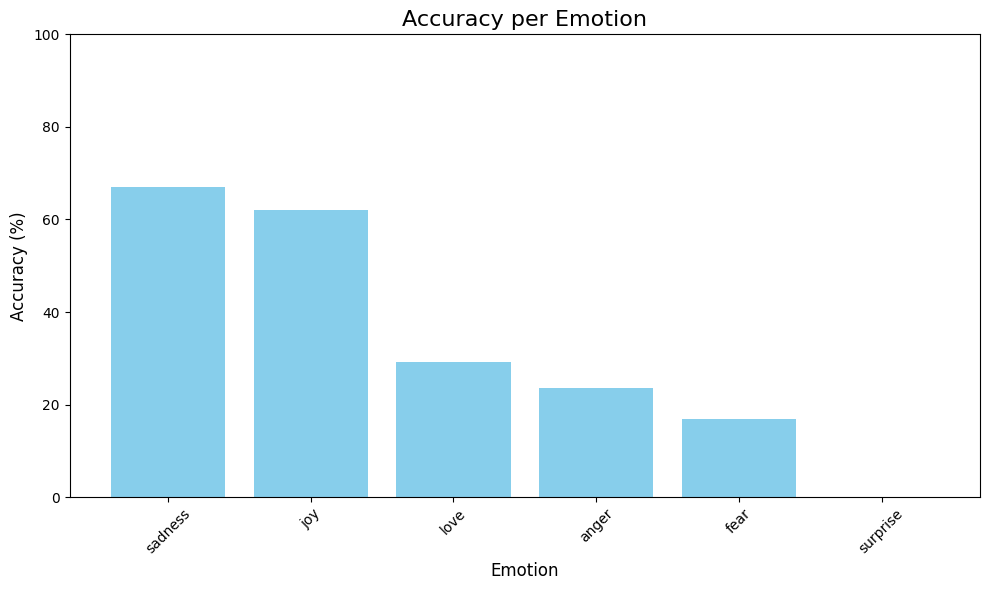

Overall Accuracy: 47.95%
Accuracy per emotion:
sadness: 67.09%
joy: 62.07%
love: 29.21%
anger: 23.64%
fear: 16.98%
surprise: 0.00%


ValueError: too many values to unpack (expected 2)

In [28]:

EMBED_DIM = 128
NUM_HEADS = 4
NUM_LAYERS = 2
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
EPOCHS = 10

learning_rates = [1e-5, 5e-4, 1e-3]
weight_decays = [0.0, 1e-2, 1e-3]
dropouts = [0.01, 0.1, 0.2]

best_accuracy = 0
best_lr = None
best_weight_decay = None
best_dropout = None

for lr in learning_rates:
    for weight_decay in weight_decays:
        for dropout in dropouts:
            
            print(f"Learning Rate: {lr}, Weight Decay: {weight_decay}, Dropout: {dropout}")
            model = TransformerModel(
                vocab_size=len(vocab),
                embed_dim=EMBED_DIM,
                num_heads=NUM_HEADS,
                num_layers=NUM_LAYERS,
                num_classes=NUM_CLASSES,
                max_len=MAX_LEN,
                dropout=dropout,
            ).to(DEVICE)

            criterion = nn.CrossEntropyLoss()
            optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

            train_model(model, train_loader, val_loader, criterion, optimizer, EPOCHS)

            emotion_accuracy, overall_accuracy = evaluate_model(
                model=model,
                data_loader=val_loader,
                index_to_emotion=INDEX_TO_EMOTION,
                device=DEVICE
            )

            if overall_accuracy > best_accuracy:
                best_accuracy = overall_accuracy
                best_lr = lr
                best_weight_decay = weight_decay
                best_dropout = dropout
    
print(f"Best Accuracy: {best_accuracy:.2f}%")
print(f"Best Learning Rate: {best_lr}")
print(f"Best Weight Decay: {best_weight_decay}")
print(f"Best Dropout: {best_dropout}")
